In [1]:
%%html
<script>
    // AUTORUN ALL CELLS ON NOTEBOOK-LOAD!
    require(
        ['base/js/namespace', 'jquery'], 
        function(jupyter, $) {
            $(jupyter.events).on("kernel_ready.Kernel", function () {
                console.log("Auto-running all cells-below...");
                jupyter.actions.call('jupyter-notebook:run-all-cells-below');
                jupyter.actions.call('jupyter-notebook:save-notebook');
            });
        }
    );
</script>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (15, 5)
# Load a sort of library file with csv column names, shared with script that preps csv files for import
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import prepcsv.lib.prepcsv as prepcsv
csv_columns = prepcsv.file_columns
print(csv_columns.keys())

df = {}
for filename, column_names in csv_columns.items():
    cols = [c for c in csv_columns[filename] if c != 'url']
    df[filename] = pd.read_csv(f'./f1db_csv/{filename}.csv', usecols=cols)

dict_keys(['constructors', 'races', 'circuits', 'results', 'driver', 'driver_standings', 'qualifying', 'status'])


In [3]:
# Merge dataset to get all the data in a couple of usefull (but big) dataframes

def join_datasets(left, right, on):
    return df[left].join(df[right].set_index(on), on=on, rsuffix=f'_{right}')
df['RaCi']         = join_datasets('races', 'circuits', 'circuitId')
df['ReDr']         = join_datasets('results', 'driver', 'driverId') 
df['ReDrCo']       = join_datasets('ReDr', 'constructors', 'constructorId')
df['ReDrCoRaCi']   = join_datasets('ReDrCo', 'RaCi', 'raceId')
df['ReDrCoRaCiSt'] = join_datasets('ReDrCoRaCi', 'status', 'statusId')
df['StDr']         = join_datasets('driver_standings', 'driver', 'driverId')
df['StDrRa']       = join_datasets('StDr', 'races', 'raceId')
big_results = df['ReDrCoRaCiSt']
big_results

,resultId,raceId,driverId,constructorId,number,grid,position,postionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,driverRef,number_driver,code,forename,surname,dob,nationality,constructorRef,teamName,nationality_constructors,year,round,circuitId,circuitName,date,time_RaCi,circuitRef,circuitName_circuits,location,country,lat,lng,alt,status
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,mclaren,McLaren,British,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.9680,10,Finished
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,bmw_sauber,BMW Sauber,German,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.9680,10,Finished
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,williams,Williams,British,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.9680,10,Finished
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,renault,Renault,French,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.9680,10,Finished
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,mclaren,McLaren,British,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.9680,10,Finished
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24575,24581,1028,842,5,10,10,16,16,16,0.0,54,\N,\N,31,16,1:40.850,196.795,22,gasly,10,GAS,Pierre,Gasly,1996-02-07,French,toro_rosso,Toro Rosso,Italian,2019,19,69,United States Grand Prix,2019-11-03,19:10:00,americas,Circuit of the Americas,Austin,USA,30.1328,-97.6411,\N,Suspension
24576,24582,1028,847,3,63,18,17,17,17,0.0,54,\N,\N,54,17,1:41.239,196.039,12,russell,63,RUS,George,Russell,1998-02-15,British,williams,Williams,British,2019,19,69,United States Grand Prix,2019-11-03,19:10:00,americas,Circuit of the Americas,Austin,USA,30.1328,-97.6411,\N,+2 Laps
24577,24583,1028,825,210,20,12,18,18,18,0.0,52,\N,\N,42,12,1:40.347,197.781,23,kevin_magnussen,20,MAG,Kevin,Magnussen,1992-10-05,Danish,haas,Haas F1 Team,American,2019,19,69,United States Grand Prix,2019-11-03,19:10:00,americas,Circuit of the Americas,Austin,USA,30.1328,-97.6411,\N,Brakes
24578,24584,1028,9,3,88,19,\N,R,19,0.0,31,\N,\N,22,20,1:43.830,191.147,44,kubica,88,KUB,Robert,Kubica,1984-12-07,Polish,williams,Williams,British,2019,19,69,United States Grand Prix,2019-11-03,19:10:00,americas,Circuit of the Americas,Austin,USA,30.1328,-97.6411,\N,Oil leak


## Print how many victorys, and the list of victories

In [4]:
def wins_of_driver(driver):
    res = big_results[(big_results['driverRef'] == driver) & (big_results['position'] == '1')]
    print(len(res))
    print(res[['year','circuitName']])
wins_of_driver('max_verstappen')

7
       year           circuitName
23000  2016    Spanish Grand Prix
23657  2017  Malaysian Grand Prix
23717  2017    Mexican Grand Prix
23937  2018   Austrian Grand Prix
24137  2018    Mexican Grand Prix
24360  2019   Austrian Grand Prix
24400  2019     German Grand Prix


## Plot the number of races per season

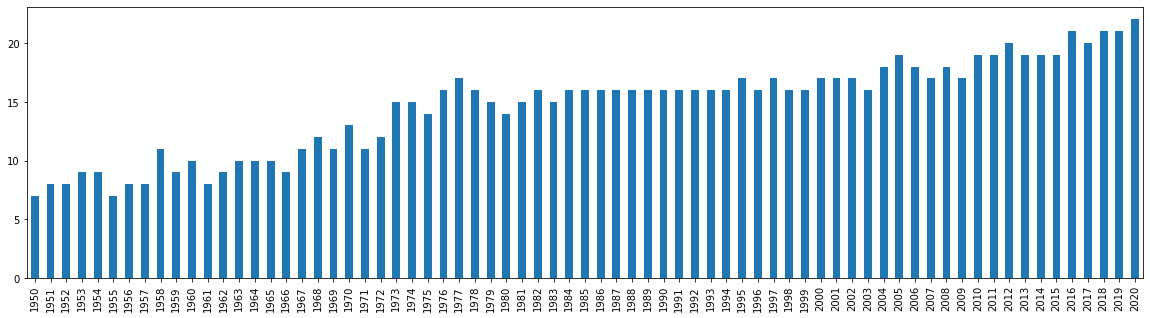

In [5]:
season_lengths = { year : len(df['races'][df['races']['year'] == year]) for year in range(1950, 2021)}
ts = pd.Series(season_lengths)
p = ts.plot(kind='bar', figsize=(20,5))
plt.show()

## Number of race wins per driver

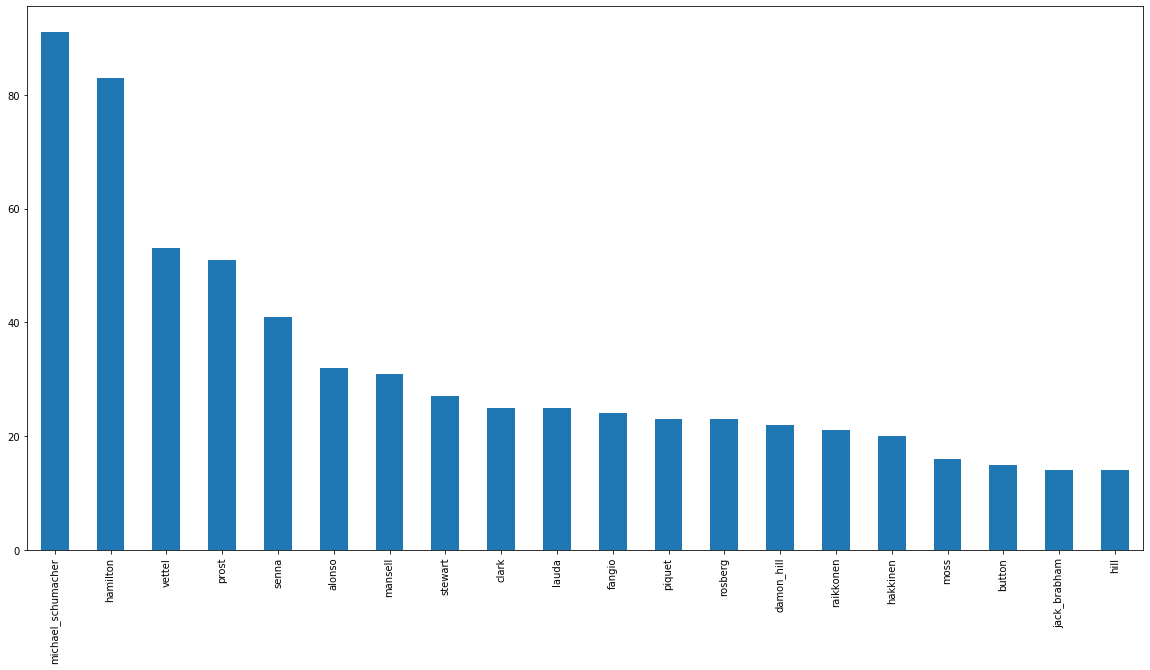

michael_schumacher    91
hamilton              83
vettel                53
prost                 51
senna                 41
alonso                32
mansell               31
stewart               27
clark                 25
lauda                 25
fangio                24
piquet                23
rosberg               23
damon_hill            22
raikkonen             21
hakkinen              20
moss                  16
button                15
jack_brabham          14
hill                  14
Name: driverRef, dtype: int64

In [6]:
# winning_drivers = df_results_drivers_races_constructors[df_results_drivers['position'] == '1']
winning_drivers = big_results[big_results['position'] == '1']
win_counts = winning_drivers['driverRef'].value_counts()
win_counts[:20].plot(kind="bar", figsize=(20,10))
plt.show()
win_counts[:20]

In [7]:
def when_champion(year):
    season_length = len(df['races'][df['races']['year'] == year])
    standings = df['StDrRa']
    season_races = pd.Series(df['ReDrCoRaCi'][df['ReDrCoRaCi']['year'] == year]['raceId'])
    season_standings = standings[standings['raceId'].isin(season_races)]
    points_for_winning = df['ReDrCoRaCi'][df['ReDrCoRaCi']['raceId'].isin(season_races)]['points'].max()
    for roundNumber in range(1,season_length+1):
        r = season_standings[season_standings['round'] == roundNumber]
        leader = r[r['position'] == 1]
        runnerup = r[r['position'] == 2]
        rounds_left = season_length - roundNumber
        if (rounds_left * points_for_winning) < leader.iloc[0]['points'] - runnerup.iloc[0]['points']:
            return (roundNumber, season_length, leader)
when_champion(2016)

(21,
 21,
        driverStandingsId  raceId  driverId  points  position positionText  \
 31254              68132     968         3   385.0         1            1   
 
        wins driverRef number code forename  surname         dob nationality  \
 31254     9   rosberg      6  ROS     Nico  Rosberg  1985-06-27      German   
 
        year  round  circuitId           circuitName        date      time  
 31254  2016     21         24  Abu Dhabi Grand Prix  2016-11-27  13:00:00  )

## List every seasons champion

In [8]:
season_lengths = { year : len(df['races'][df['races']['year'] == year]) for year in range(1950, 2021)}
standings = df['StDrRa']
champs = {}
for year in range(1950, 2020):
    season_races = pd.Series(df['races'][df['races']['year'] == year]['raceId'])
    season_standings = standings[standings['raceId'].isin(season_races)]
    last_round = season_standings[season_standings['round'] == season_lengths[year]]
    # champion = last_round[last_round['position'] == 1]
    when = when_champion(year)
    champion = when[2]
    percentage = when[0]/(when[1]/100)
    champs[year] =  champion.iloc[0]['driverRef']
    print('{}: {} {} {}/{} {:.1f}'.format(champion.iloc[0]['year'], 
                                champion.iloc[0]['forename'], 
                                champion.iloc[0]['surname'],
                                when[0],when[1],
                                percentage))

1950: Nino Farina 7/7 100.0
1951: Juan Fangio 8/8 100.0
1952: Alberto Ascari 7/8 87.5
1953: Alberto Ascari 8/9 88.9
1954: Juan Fangio 7/9 77.8
1955: Juan Fangio 6/7 85.7
1956: Juan Fangio 8/8 100.0
1957: Juan Fangio 7/8 87.5
1958: Mike Hawthorn 11/11 100.0
1959: Jack Brabham 9/9 100.0
1960: Jack Brabham 10/10 100.0
1961: Phil Hill 8/8 100.0
1962: Graham Hill 9/9 100.0
1963: Jim Clark 8/10 80.0
1964: John Surtees 10/10 100.0
1965: Jim Clark 8/10 80.0
1966: Jack Brabham 7/9 77.8
1967: Denny Hulme 11/11 100.0
1968: Graham Hill 12/12 100.0
1969: Jackie Stewart 8/11 72.7
1970: Jochen Rindt 12/13 92.3
1971: Jackie Stewart 8/11 72.7
1972: Emerson Fittipaldi 10/12 83.3
1973: Jackie Stewart 13/15 86.7
1974: Emerson Fittipaldi 15/15 100.0
1975: Niki Lauda 13/14 92.9
1976: James Hunt 16/16 100.0
1977: Niki Lauda 15/17 88.2
1978: Mario Andretti 15/16 93.8
1979: Jody Scheckter 15/15 100.0
1980: Alan Jones 14/14 100.0
1981: Nelson Piquet 15/15 100.0
1982: Keke Rosberg 16/16 100.0
1983: Nelson Piquet

## Plot season lenght vs when the champion was known

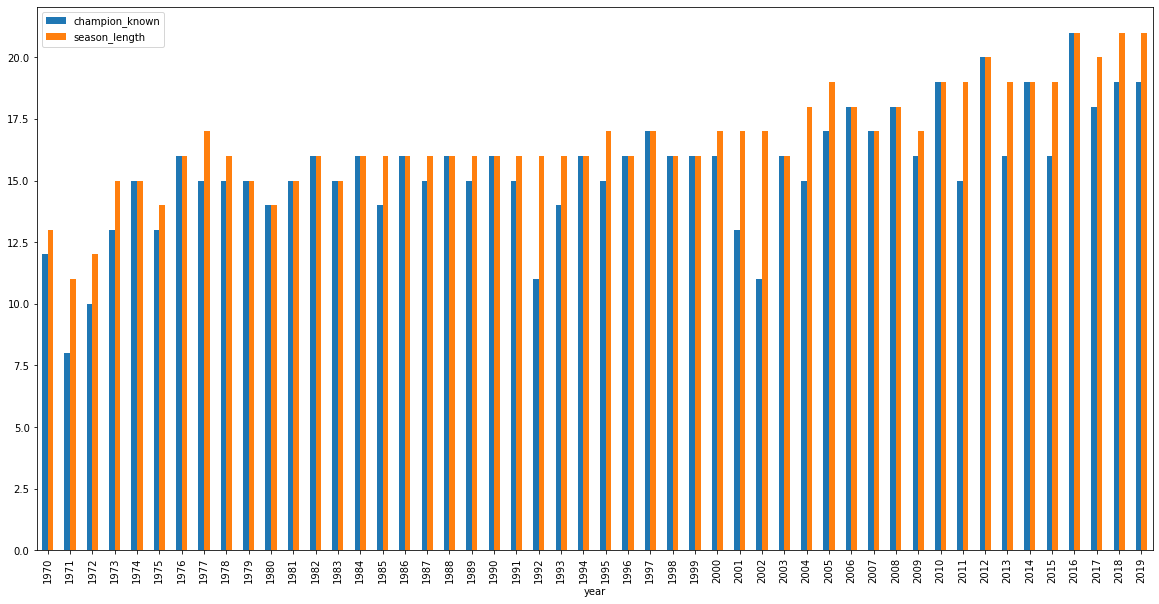

In [9]:
season_lengths = { year : len(df['races'][df['races']['year'] == year]) for year in range(1950, 2021)}
season_stacked = {}
for year in range(1950, 2020):
    season_stacked[year] = when_champion(year)

rows = zip(season_lengths.keys(), 
           [v[0] for v in season_stacked.values()],
           [v[1] for v in season_stacked.values()])
headers = ['year', 'champion_known', 'season_length']
stacked = pd.DataFrame(rows, columns=headers).set_index('year')[20:]

stacked.plot(kind='bar', figsize=(20,10))

## Dnf percentage per driver

Mercedes - Lewis Hamilton: 89.5%
Mercedes - Valtteri Bottas: 90.6%
Ferrari - Charles Leclerc: 80.0%
Red Bull - Max Verstappen: 79.0%
Ferrari - Sebastian Vettel: 85.4%
McLaren - Lando Norris: 68.4%
Alfa Romeo - Kimi Räikkönen: 77.3%
Red Bull - Pierre Gasly: 82.2%
Toro Rosso - Alexander Albon: 94.7%
Racing Point - Sergio Pérez: 85.2%
Alfa Romeo - Antonio Giovinazzi: 85.7%
Toro Rosso - Daniil Kvyat: 76.3%
Haas F1 Team - Kevin Magnussen: 82.2%
Racing Point - Lance Stroll: 85.0%
Williams - George Russell: 89.5%
Williams - Robert Kubica: 84.2%
Renault - Nico Hülkenberg: 77.4%
Renault - Daniel Ricciardo: 81.1%
McLaren - Carlos Sainz: 75.0%
Haas F1 Team - Romain Grosjean: 70.7%


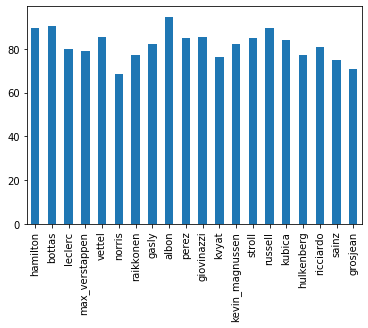

In [10]:
br = big_results
# print(br.columns)
twenty_nineteen_drivers = br[(br['year'] == 2019) & (br['round'] == 2)]
driver_stats = {}
for i in range(len(twenty_nineteen_drivers)):
    driverId = twenty_nineteen_drivers.iloc[i]['driverId']
    all_races = br[br.driverId == driverId]
    finished = all_races[(all_races.status.str.contains('^\+')) | (all_races.status.str.contains('Finished'))]
    percentage = len(finished)/(len(all_races)/100)
    print('{} - {} {}: {:.1f}%'.format(twenty_nineteen_drivers.iloc[i]['teamName'],
                                  twenty_nineteen_drivers.iloc[i]['forename'],
                                  twenty_nineteen_drivers.iloc[i]['surname'],
                                  percentage))
    driver_stats[twenty_nineteen_drivers.iloc[i]['driverRef']] = percentage
pd.Series(driver_stats).plot(kind='bar')    

## Circuits a driver has never won

In [11]:
won = br[(br['driverRef'] == 'hamilton') & (br['position'] == '1')]
circuits_won = set([race for race in won['circuitName']])
races_2019 = df['RaCi'][df['RaCi']['year'] == 2019]
for circuit in races_2019['circuitName']:
    if circuit not in circuits_won:
        print(circuit)

## Lap times over the years per circuit (in progress)

In [12]:
qualy = df['qualifying']
fastest_laps = qualy[qualy['position'] == 1]
fastest_laps[:20]

,qualifyingId,raceId,driverId,constructorId,number,position,q1,q2,q3
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
22,23,19,13,6,2,1,1:35.347,1:34.412,1:35.748
44,45,20,9,2,4,1,1:32.893,1:31.745,1:33.096
66,67,21,8,6,1,1,1:20.701,1:20.784,1:21.813
88,89,22,13,6,2,1,1:25.994,1:26.192,1:27.617
108,109,23,13,6,2,1,1:15.190,1:15.110,1:15.787
128,129,24,1,1,22,1,1:16.909,1:17.034,1:17.886
148,149,25,8,6,1,1,1:15.133,1:15.161,1:16.449
168,169,26,5,1,23,1,1:19.957,1:19.597,1:21.049
188,189,27,1,1,22,1,1:15.218,1:14.603,1:15.666


## Print the circuits a driver has won and the years he has done it

In [13]:
driverRef = 'hamilton'
winning_races = br[(br['position'] == '1') & (br['driverRef'] == driverRef)]
winning_years = {}
for index, race in winning_races.iterrows():
    r = ''
    try:
        if champs[race['year']] == driverRef:
            r = str(race['year']) + '*'
        else:
            r = str(race['year']) + ' '
    except KeyError:
        continue
    try:
        winning_years[race['circuitName']].append(r)
    except KeyError:
        winning_years[race['circuitName']] = [r]
sorted_keys = sorted(winning_years, key=lambda k: len(winning_years[k]), reverse=True)
for race in sorted_keys:
    padding = 26 - len(race)
    print('{}:{}{}'.format(race, ' '*padding, ', '.join(winning_years[race]))) 

Canadian Grand Prix:       2007 , 2010 , 2012 , 2015*, 2016 , 2017*, 2019*
Hungarian Grand Prix:      2007 , 2009 , 2012 , 2013 , 2016 , 2018*, 2019*
British Grand Prix:        2008*, 2014*, 2015*, 2016 , 2017*, 2019*
Chinese Grand Prix:        2008*, 2011 , 2014*, 2015*, 2017*, 2019*
United States Grand Prix:  2007 , 2012 , 2014*, 2015*, 2016 , 2017*
Japanese Grand Prix:       2007 , 2014*, 2015*, 2017*, 2018*
Italian Grand Prix:        2012 , 2014*, 2015*, 2017*, 2018*
German Grand Prix:         2008*, 2011 , 2016 , 2018*
Singapore Grand Prix:      2009 , 2014*, 2017*, 2018*
Abu Dhabi Grand Prix:      2011 , 2014*, 2016 , 2018*
Spanish Grand Prix:        2014*, 2017*, 2018*, 2019*
Russian Grand Prix:        2014*, 2015*, 2018*, 2019*
Monaco Grand Prix:         2008*, 2016 , 2019*
Belgian Grand Prix:        2010 , 2015*, 2017*
Bahrain Grand Prix:        2014*, 2015*, 2019*
Australian Grand Prix:     2008*, 2015*
Mexican Grand Prix:        2016 , 2019*
Brazilian Grand Prix:      2016 ,

## Same as above, different representation

In [14]:
def winning_circuits(driverRef):
    winning_races = br[(br['position'] == '1') & (br['driverRef'] == driverRef)]
    winning_years = {}
    for index, race in winning_races.iterrows():
        r = ''
        try:
            if champs[race['year']] == driverRef:
                r = str(race['year']) + 'C'
            else:
                r = str(race['year']) + ' '
        except KeyError:
            r = str(race['year']) + ' ' 
        try:
            winning_years[race['circuitName']].append(r)
        except KeyError:
            winning_years[race['circuitName']] = [r]
    from more_itertools import flatten
    years = sorted(set(flatten(winning_years.values())))
    print('{} | {}  (C=champion)'.format(26*' ', '| '.join([y[2:] for y in years]))) # header 
    sorted_keys = sorted(winning_years)
    for race in sorted_keys:
        padding = 26 - len(race)
        s = '{}:{}'.format(race, ' '*padding)
        for y in years:
            if y in winning_years[race]:
                s += '| *  '
            else:
                s += '|    '    
        print(s)
winning_circuits('hamilton')

                           | 07 | 08C| 09 | 10 | 11 | 12 | 13 | 14C| 15C| 16 | 17C| 18C| 19C  (C=champion)
Abu Dhabi Grand Prix:      |    |    |    |    | *  |    |    | *  |    | *  |    | *  |    
Australian Grand Prix:     |    | *  |    |    |    |    |    |    | *  |    |    |    |    
Austrian Grand Prix:       |    |    |    |    |    |    |    |    |    | *  |    |    |    
Azerbaijan Grand Prix:     |    |    |    |    |    |    |    |    |    |    |    | *  |    
Bahrain Grand Prix:        |    |    |    |    |    |    |    | *  | *  |    |    |    | *  
Belgian Grand Prix:        |    |    |    | *  |    |    |    |    | *  |    | *  |    |    
Brazilian Grand Prix:      |    |    |    |    |    |    |    |    |    | *  |    | *  |    
British Grand Prix:        |    | *  |    |    |    |    |    | *  | *  | *  | *  |    | *  
Canadian Grand Prix:       | *  |    |    | *  |    | *  |    |    | *  | *  | *  |    | *  
Chinese Grand Prix:        |    | *  |    |    | *  |   

In [15]:
winning_circuits('siffert')

                           | 68 | 71   (C=champion)
Austrian Grand Prix:       |    | *  
British Grand Prix:        | *  |    
